### Precipitation Efficiency

In [1]:
import sys
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import metpy.calc as mpc
from metpy.units import units
# for animations
from PIL import Image

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def LSPE2_calc(exp_dir,t_sampling=144):
    os.chdir('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'+exp_dir)
    
    data = xr.open_dataset('cm1out_sub3d.nc')
    u = data.uinterp[-t_sampling:,:,:]
    v = data.vinterp[-t_sampling:,:,:]
    w = data.winterp[-t_sampling:,:,:]
    qv = data.qv[-t_sampling:,:,:]
    
    data = xr.open_dataset('cm1out_q3d.nc')
    qc = data.qc[-t_sampling:,:,:]
    qi = data.qi[-t_sampling:,:,:]
#    qr = data.qr[-t_sampling:,:,:]
#    qs = data.qs[-t_sampling:,:,:]
#    qg = data.qg[-t_sampling:,:,:]

    data2 = xr.open_dataset('cm1out_2Dvars.nc')
    prate = data2.prate
    prate = prate[-t_sampling:,:,:] # kg/m^2/s
    data_zon = xr.open_dataset('cm1out_zonmean.nc')
    prs = data_zon.prs[-t_sampling:,:,:,:]
    th = data_zon.th[-t_sampling:,:,:,:]
    
    try:
        data3 = xr.open_dataset('cm1out_SFX.nc')
        qfx = data3.qfx[-t_sampling:,:,:].values # kg/m^2/s
    except:
        qfx = np.ones(prate.shape)*1.41203e-4

    # ----------------------------------------
    z_dim = qv.lev*1000
    
    # temperature conversion
    T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
    # density 
    ro = prs/(287.15*(T+273.15))
    
    ro = ro[-t_sampling:,:,0,0]
    ro = np.tile(ro,(qv.shape[2],qv.shape[3],1,1))
    ro = ro.swapaxes(0,2)
    ro = ro.swapaxes(1,3) # air density kg/m^3
    print(ro.shape)

    # 1. calculate large-scale precipitaiton efficiency (LSPE2), Sui et al., 2007 =======
    # all units are kg/m^2/s
    tmp = np.trapz(ro*qv,z_dim,axis=1)
    Q_wvt = -np.gradient(tmp,20*60,axis=0) # local loss of vertically-integrated water vapor, - d[qv]/dt [kg/m^3/s]

    tmp = -(np.gradient(qv*u,2000,axis=3) + np.gradient(qv*v,2000,axis=2)) 
    Q_wvf = np.trapz(ro*tmp,z_dim,axis=1) # vertically-integrated moisture flux convergence -div(qv*u) 

    Q_wve = qfx # surface evaporation rate 

    c1 = qc + qi #qr + qi + qs + qg # hydrometeors 
    tmp = -(np.gradient(c1*u,2000,axis=3) + np.gradient(c1*v,2000,axis=2)) 
    conv_c = np.trapz(ro*tmp,z_dim,axis=1) # vertically-integrated conv_c

    tmp = np.trapz(ro*c1,z_dim,axis=1)
    Q_cm = -np.gradient(tmp,20*60,axis=0) + conv_c # -d[c]/dt + [conv_c] 

    Ps = Q_wvt + Q_wvf + Q_wve + Q_cm

    # set zero if values are negative (not sources for P)
    Q_wvt[Q_wvt<0] = 0
    Q_wvf[Q_wvf<0] = 0
    Q_wve[Q_wve<0] = 0
    Q_cm[Q_cm<0] = 0

    LSPE2 = prate.values/(Q_wvt + Q_wvf + Q_wve + Q_cm)
    LSPE2_Qcm = prate.values/Q_cm
    # ===============================
    
    # 2. condensate heating
    data3 = xr.open_dataset('cm1out_qvbgt.nc')
    tmp = data3.qt_cond[-t_sampling:,:,:,:] + data3.qt_dep[-t_sampling:,:,:,:]
    cond_heat = np.trapz(ro*tmp,z_dim,axis=1) # qv loss [kg/m^2/s]
    
    return LSPE2, prate, LSPE2_Qcm, cond_heat

In [4]:
# get weather or weather2 
server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
exp_name = ['CM1_RAD4K_RCEP_240x240_CTRL']

#os.chdir(server + exp_name)
os.system('mkdir -p fig_sum') # create a figure archive
fig_dir = server+'fig_sum' 

(144, 65, 240, 240)


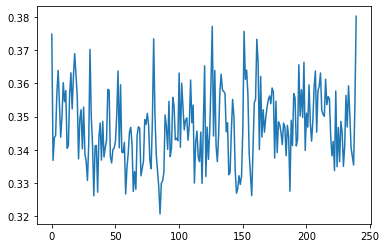

In [5]:
LSPE2,prate,LSPE2_Qcm,cond_heat = LSPE2_calc(exp_name[0],t_sampling=144)
tmp = 3600*prate.values # [mm/h]
LSPE2[LSPE2<=0] = np.nan
LSPE2[LSPE2<=0] = np.nan # only precipitating grids
plt.plot(np.nanmean(prate,axis=(0,2))/-np.nanmean(cond_heat,axis=(0,2)))

In [ ]:
plt.plot(np.nanmean(LSPE2,axis=(0,2)))

In [ ]:
os.chdir(server+exp_name[0])
os.system('mkdir -p data_out')
os.chdir(server+exp_name[0]+'/data_out/')
print(os.getcwd())
np.save('LSPE2_ydist.npy',100*np.nanmean(LSPE2,axis=(0,2)))

### Diagnosis section for existing outputs

In [ ]:
server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
exp_name = ['CM1_RAD4K_RCEP_240x240_CTRL',
            'CM1_RAD4K_RCEP_240x240_lowU05',
            'CM1_RAD4K_RCEP_240x240_lowU07',
            'CM1_RAD4K_RCEP_240x240_lowU10',
            'CM1_RAD4K_RCEP_240x240_lowU12',
            'CM1_RAD4K_RCEP_240x240_lowU15',
            'CM1_RAD4K_RCEP_240x240_lowU05_UNI',
            'CM1_RAD4K_RCEP_240x240_lowU10_UNI',
            'CM1_RAD4K_RCEP_240x240_lowU15_UNI']

exp_short = ['CTRL','U05','U07','U10','U12','U15','U05_UNI','U10_UNI','U15_UNI']

In [ ]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N

    y_avg = np.convolve(y, avg_mask, 'same')
    y_avg[-window_N:] = y[-window_N:]
    y_avg[:window_N] = y[:window_N]
    return y_avg    

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

y_dim = np.linspace(0,480,240)

colors = ['k','moccasin','wheat','orange','darkorange','r','b','orange','r']
linestyles = ['-','-','-','-','-','-',':',':',':']
markers = ['^','o','s']

m=0
for n,exp in enumerate(exp_name[:]):
    data = np.load(server+exp+'/data_out/LSPE2_ydist.npy')
    if n < 6:
        ax.plot(y_dim,running_mean(data,5),label=exp_short[n],color=colors[n],linestyle=linestyles[n])
    else:
        ax.scatter(240,data.mean(),color='k',marker=markers[m])
        m+=1
ax.legend()
ax.set_xlim([0,480]);ax.set_xticks(np.linspace(0,480,9));
ax.set_xlabel('y direction [km]',fontsize=12)
ax.set_ylabel('LSPE2 [%]',fontsize=12)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.grid(linestyle=':')

fig.savefig(fig_dir+'/LSPE2_crosssect_newCTRL.pdf',bbox_inches='tight',transparent=False)